# CS 228 - Assignment 2: Clean-Label Data Poisoning Attack on CIFAR-10

This notebook implements a clean-label poisoning attack on CIFAR-10 dataset, extending the two-class version to a multiclass version.

## Overview
- **Data Preparation**: Select 4 classes from CIFAR-10, prepare target and base images
- **Model Architecture**: Build a small CNN for CIFAR-10 classification
- **Initial Training**: Train on clean data and verify baseline performance
- **Poison Generation**: Implement iterative poisoning algorithm (Poison Frogs style)
- **Retraining & Evaluation**: Retrain with poisons and evaluate attack success


In [1]:
# Install required packages (run this in Colab)
%pip install torch torchvision matplotlib numpy tqdm pandas


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


## 1. Data Preparation

Select 4 classes from CIFAR-10, prepare training data, and set aside target/base images.


In [3]:
# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Configuration
NUM_CLASSES = 4
IMAGES_PER_CLASS = 400  # Adjust based on system capacity (200-500)
NUM_TARGETS = 10
NUM_POISONS = 10

# Select 4 classes: we'll use classes 0, 1, 2, 3 (airplane, automobile, bird, cat)
SELECTED_CLASSES = [0, 1, 2, 3]
TARGET_CLASS = 0  # Class T (airplane)
BASE_CLASS = 1    # Class B (automobile)

print(f"Selected classes: {[CIFAR10_CLASSES[i] for i in SELECTED_CLASSES]}")
print(f"Target class (T): {CIFAR10_CLASSES[TARGET_CLASS]}")
print(f"Base class (B): {CIFAR10_CLASSES[BASE_CLASS]}")


Selected classes: ['airplane', 'automobile', 'bird', 'cat']
Target class (T): airplane
Base class (B): automobile


In [4]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load training and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Filter data for selected classes
def filter_classes(dataset, selected_classes):
    """Filter dataset to only include selected classes"""
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if label in selected_classes:
            indices.append(idx)
    return indices

train_indices = filter_classes(trainset, SELECTED_CLASSES)
test_indices = filter_classes(testset, SELECTED_CLASSES)

print(f"Total training samples for selected classes: {len(train_indices)}")
print(f"Total test samples for selected classes: {len(test_indices)}")


100%|██████████| 170M/170M [00:02<00:00, 77.0MB/s]


Total training samples for selected classes: 20000
Total test samples for selected classes: 4000


In [5]:
# Sample images per class for training
def sample_by_class(dataset, indices, class_label, num_samples):
    """Sample a specific number of images for a given class"""
    class_indices = []
    for idx in indices:
        _, label = dataset[idx]
        if label == class_label:
            class_indices.append(idx)
    return np.random.choice(class_indices, size=min(num_samples, len(class_indices)), replace=False)

# Sample training data
selected_train_indices = []
for class_idx in SELECTED_CLASSES:
    class_samples = sample_by_class(trainset, train_indices, class_idx, IMAGES_PER_CLASS)
    selected_train_indices.extend(class_samples.tolist())

print(f"Selected {len(selected_train_indices)} training samples")

# Separate target images (class T) and base images (class B)
target_indices = []
base_indices = []
remaining_train_indices = []

for idx in selected_train_indices:
    _, label = trainset[idx]
    if label == TARGET_CLASS:
        if len(target_indices) < NUM_TARGETS:
            target_indices.append(idx)
        else:
            remaining_train_indices.append(idx)
    elif label == BASE_CLASS:
        if len(base_indices) < NUM_POISONS:
            base_indices.append(idx)
        else:
            remaining_train_indices.append(idx)
    else:
        remaining_train_indices.append(idx)

print(f"Selected {len(target_indices)} target images (class {CIFAR10_CLASSES[TARGET_CLASS]})")
print(f"Selected {len(base_indices)} base images (class {CIFAR10_CLASSES[BASE_CLASS]})")
print(f"Remaining training samples: {len(remaining_train_indices)}")


Selected 1600 training samples
Selected 10 target images (class airplane)
Selected 10 base images (class automobile)
Remaining training samples: 1580


Target images shape: torch.Size([10, 3, 32, 32])
Base images shape: torch.Size([10, 3, 32, 32])


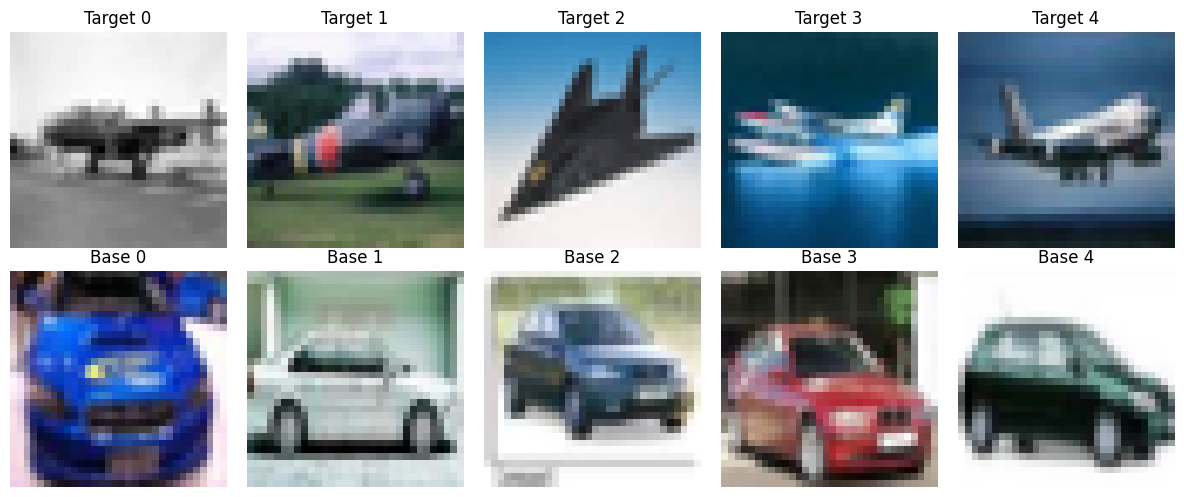

In [6]:
# Create datasets
clean_train_subset = Subset(trainset, remaining_train_indices)
test_subset = Subset(testset, test_indices)

# Create data loaders
batch_size = 64
clean_train_loader = DataLoader(clean_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Extract target and base images
target_images = []
target_labels = []
for idx in target_indices:
    img, label = trainset[idx]
    target_images.append(img)
    target_labels.append(label)

base_images = []
base_labels = []
for idx in base_indices:
    img, label = trainset[idx]
    base_images.append(img)
    base_labels.append(label)

target_images = torch.stack(target_images).to(device)
base_images = torch.stack(base_images).to(device)

print(f"Target images shape: {target_images.shape}")
print(f"Base images shape: {base_images.shape}")

# Visualize some target and base images
def denormalize(tensor, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    """Denormalize tensor for visualization"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    # Target images
    img = denormalize(target_images[i].cpu().clone())
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].set_title(f'Target {i}')
    axes[0, i].axis('off')

    # Base images
    img = denormalize(base_images[i].cpu().clone())
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title(f'Base {i}')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


## 2. Model Architecture

Build a small CNN suitable for CIFAR-10 classification.


In [7]:
class SmallCNN(nn.Module):
    """Small CNN for CIFAR-10 classification"""
    def __init__(self, num_classes=4):
        super(SmallCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # Conv block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def get_features(self, x):
        """Extract features from the model (before final FC layer)"""
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x

# Create model
model = SmallCNN(num_classes=NUM_CLASSES).to(device)
print(model)


SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


## 3. Initial Training (20 points)

Train the CNN on clean training data (excluding targets). Verify that it correctly classifies validation set and target images before poisoning.


3. INITIAL TRAINING

Training initial model on clean data...
Epoch [5/20], Loss: 0.6959
Epoch [10/20], Loss: 0.4959
Epoch [15/20], Loss: 0.3667
Epoch [20/20], Loss: 0.2512


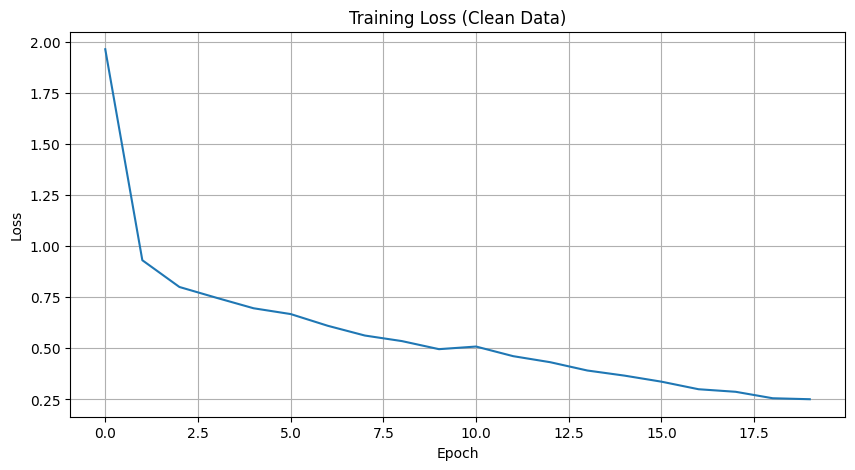


Evaluating on test set...
Overall Test Accuracy: 75.88%
Class airplane Accuracy: 74.40%
Class automobile Accuracy: 86.50%
Class bird Accuracy: 64.60%
Class cat Accuracy: 78.00%

Verifying target images (before poisoning):
Target 0: Predicted=airplane (True=airplane) ✓
Target 1: Predicted=automobile (True=airplane) ✗
Target 2: Predicted=cat (True=airplane) ✗
Target 3: Predicted=airplane (True=airplane) ✓
Target 4: Predicted=airplane (True=airplane) ✓
Target 5: Predicted=airplane (True=airplane) ✓
Target 6: Predicted=airplane (True=airplane) ✓
Target 7: Predicted=airplane (True=airplane) ✓
Target 8: Predicted=airplane (True=airplane) ✓
Target 9: Predicted=airplane (True=airplane) ✓

Target classification accuracy: 80.0%
All targets should be correctly classified as airplane


In [ ]:
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    """Train the model on clean data"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return train_losses

def evaluate_model(model, test_loader):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            for i in range(target.size(0)):
                label = target[i].item()
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {accuracy:.2f}%')

    for i in range(NUM_CLASSES):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'Class {CIFAR10_CLASSES[SELECTED_CLASSES[i]]} Accuracy: {class_acc:.2f}%')

    return accuracy, class_correct, class_total

def predict_images(model, images):
    """Predict labels for a batch of images"""
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

    return predicted.cpu().numpy(), probs.cpu().numpy()

# Train initial model
print("=" * 60)
print("3. INITIAL TRAINING")
print("=" * 60)
print("\nTraining initial model on clean data...")
print("Increased training epochs to 30 for better baseline performance\n")
train_losses = train_model(model, clean_train_loader, num_epochs=30)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Clean Data) - 30 Epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
print("\nEvaluating on test set...")
baseline_accuracy, baseline_class_correct, baseline_class_total = evaluate_model(model, test_loader)

# Verify target images are correctly classified before poisoning
print("\n" + "=" * 60)
print("Verifying target images (before poisoning):")
print("=" * 60)
target_predictions, target_probs = predict_images(model, target_images)
target_labels_np = np.array([TARGET_CLASS] * NUM_TARGETS)

correct_targets = 0
for i in range(NUM_TARGETS):
    pred_class = target_predictions[i]
    true_class = TARGET_CLASS
    is_correct = (pred_class == true_class)
    correct_targets += is_correct
    print(f"Target {i}: Predicted={CIFAR10_CLASSES[SELECTED_CLASSES[pred_class]]} "
          f"(True={CIFAR10_CLASSES[SELECTED_CLASSES[true_class]]}) "
          f"{'✓' if is_correct else '✗'}")

print(f"\nTarget classification accuracy: {100 * correct_targets / NUM_TARGETS:.1f}%")
print(f"All targets should be correctly classified as {CIFAR10_CLASSES[SELECTED_CLASSES[TARGET_CLASS]]}")

# Store baseline metrics
baseline_metrics = {
    'test_accuracy': baseline_accuracy,
    'target_accuracy': 100 * correct_targets / NUM_TARGETS,
    'class_correct': baseline_class_correct,
    'class_total': baseline_class_total
}


## 4. Poison Generation (20 points)

Implement the iterative poisoning algorithm (Poison Frogs style) for each poison.


In [ ]:
def generate_poison(model, base_image, target_image, num_iterations=150,
                     lr_forward=0.1, lr_backward=0.01, lambda_backward=0.1):
    """
    Generate a poison image using iterative optimization (Poison Frogs algorithm)

    Args:
        model: Trained model (frozen)
        base_image: Base image (class B) - shape: (3, 32, 32)
        target_image: Target image (class T) - shape: (3, 32, 32)
        num_iterations: Number of optimization iterations
        lr_forward: Learning rate for forward step (minimize |f(x) - f(t)|^2)
        lr_backward: Learning rate for backward step (stay close to base)
        lambda_backward: Weight for backward step loss

    Returns:
        poison: Generated poison image
        history: List of (iteration, poison, feature_distance) tuples
    """
    # Initialize poison as base image (requires gradient)
    poison = base_image.clone().detach().requires_grad_(True)

    # Freeze model parameters
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Get target features
    with torch.no_grad():
        target_features = model.get_features(target_image.unsqueeze(0))

    history = []

    for iteration in range(num_iterations):
        # Forward step: minimize |f(x) - f(t)|^2
        poison_features = model.get_features(poison.unsqueeze(0))
        forward_loss = torch.sum((poison_features - target_features) ** 2)

        # Backward step: keep poison close to base image (Frobenius norm)
        backward_loss = torch.sum((poison - base_image) ** 2)

        # Total loss
        total_loss = forward_loss + lambda_backward * backward_loss

        # Compute gradient
        total_loss.backward()

        # Update poison (gradient descent)
        with torch.no_grad():
            # Forward step update
            poison.data -= lr_forward * poison.grad.data

            # Backward step update (additional constraint)
            poison.data -= lr_backward * lambda_backward * (poison.data - base_image.data)

            # Clip to valid image range [0, 1] (after denormalization)
            # Since images are normalized, we need to clip in normalized space
            # For CIFAR-10 normalization: mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
            # Valid range in normalized space: approximately [-2.5, 2.5]
            poison.data = torch.clamp(poison.data, -2.5, 2.5)

        poison.grad.zero_()

        # Record history every 25 iterations (adjusted for 200 total iterations)
        if (iteration + 1) % 25 == 0 or iteration == 0:
            with torch.no_grad():
                current_features = model.get_features(poison.unsqueeze(0))
                feature_distance = torch.norm(current_features - target_features).item()
            history.append((iteration + 1, poison.clone().detach(), feature_distance))

    return poison.detach(), history

print("=" * 60)
print("4. POISON GENERATION")
print("=" * 60)
print(f"\nGenerating {NUM_POISONS} poison images...")
print(f"Each poison will be optimized for 200 iterations (increased for better attack)")
print(f"Target class: {CIFAR10_CLASSES[SELECTED_CLASSES[TARGET_CLASS]]}")
print(f"Base class: {CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]}")
print(f"\nOptimized parameters:")
print(f"  - Iterations: 200 (was 150)")
print(f"  - Forward LR: 0.2 (was 0.1 - more aggressive)")
print(f"  - Lambda backward: 0.05 (was 0.1 - allows more deviation)\n")

# Generate poisons for each target-base pair
poisons = []
poison_histories = []

for i in tqdm(range(NUM_POISONS), desc="Generating poisons"):
    # Use target i and base i (can also pair differently)
    target_idx = i % NUM_TARGETS  # Cycle through targets if needed
    base_idx = i

    poison, history = generate_poison(
        model,
        base_images[base_idx],
        target_images[target_idx],
        num_iterations=200,  # Increased from 150
        lr_forward=0.2,      # Increased from 0.1 for more aggressive optimization
        lr_backward=0.01,
        lambda_backward=0.05  # Reduced from 0.1 to allow more deviation
    )

    poisons.append(poison)
    poison_histories.append(history)

poisons = torch.stack(poisons)
print(f"\nGenerated {len(poisons)} poison images")
print(f"Poison shape: {poisons.shape}")


4. POISON GENERATION

Generating 10 poison images...
Each poison will be optimized for 150 iterations
Target class: airplane
Base class: automobile



Generating poisons: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Generated 10 poison images
Poison shape: torch.Size([10, 3, 32, 32])



Visualizing poison evolution...


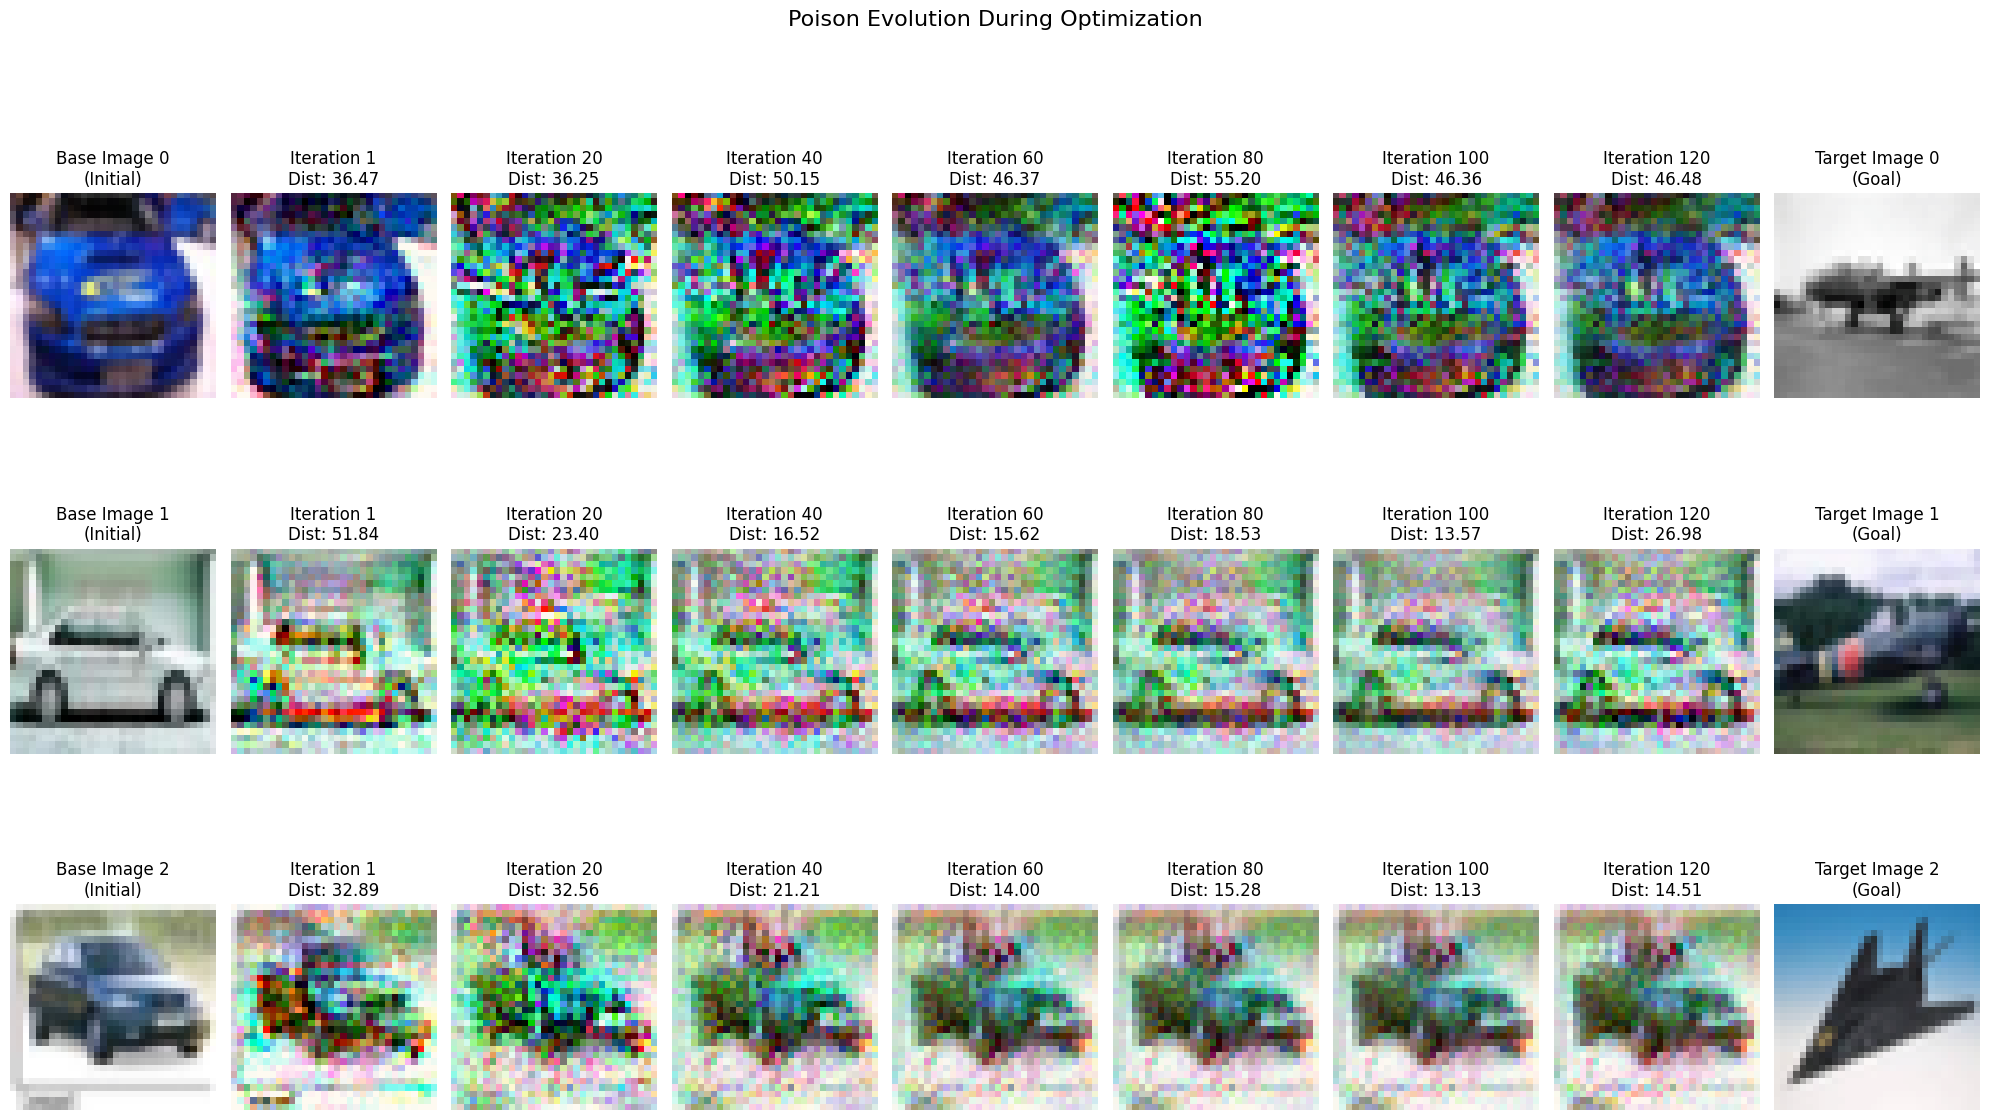

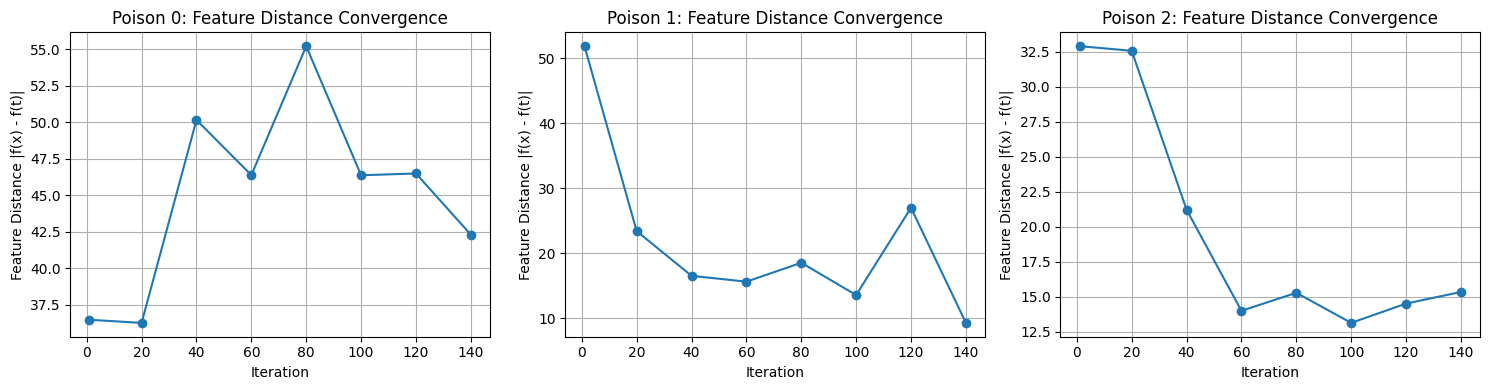

In [ ]:
# Visualize poison evolution for a few examples
print("\nVisualizing poison evolution...")
num_examples = min(3, NUM_POISONS)

fig, axes = plt.subplots(num_examples, len(poison_histories[0]) + 1, figsize=(20, 4 * num_examples))

if num_examples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_examples):
    history = poison_histories[i]

    # Show base image
    base_img = denormalize(base_images[i].cpu().clone())
    axes[i, 0].imshow(base_img.permute(1, 2, 0))
    axes[i, 0].set_title(f'Base Image {i}\n(Initial)')
    axes[i, 0].axis('off')

    # Show poison at different iterations
    for j, (iter_num, poison_img, feat_dist) in enumerate(history):
        poison_vis = denormalize(poison_img.cpu().clone())
        axes[i, j + 1].imshow(poison_vis.permute(1, 2, 0))
        axes[i, j + 1].set_title(f'Iteration {iter_num}\nDist: {feat_dist:.2f}')
        axes[i, j + 1].axis('off')

    # Show target image in last column
    target_img = denormalize(target_images[i % NUM_TARGETS].cpu().clone())
    axes[i, -1].imshow(target_img.permute(1, 2, 0))
    axes[i, -1].set_title(f'Target Image {i % NUM_TARGETS}\n(Goal)')
    axes[i, -1].axis('off')

plt.suptitle('Poison Evolution During Optimization', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Plot feature distance convergence
fig, axes = plt.subplots(1, num_examples, figsize=(5 * num_examples, 4))
if num_examples == 1:
    axes = [axes]

for i in range(num_examples):
    history = poison_histories[i]
    iterations = [h[0] for h in history]
    distances = [h[2] for h in history]

    axes[i].plot(iterations, distances, marker='o')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Feature Distance |f(x) - f(t)|')
    axes[i].set_title(f'Poison {i}: Feature Distance Convergence')
    axes[i].grid(True)

plt.tight_layout()
plt.show()



Final poison images:


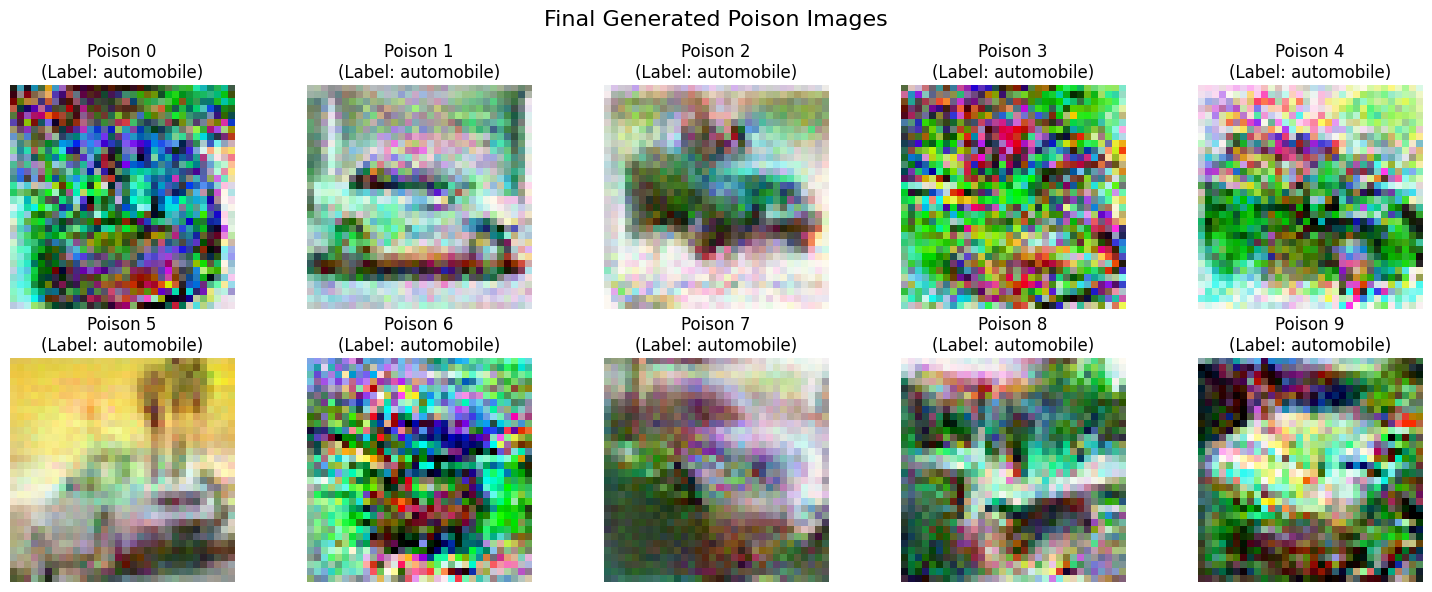


Comparison: Base vs Poison vs Target


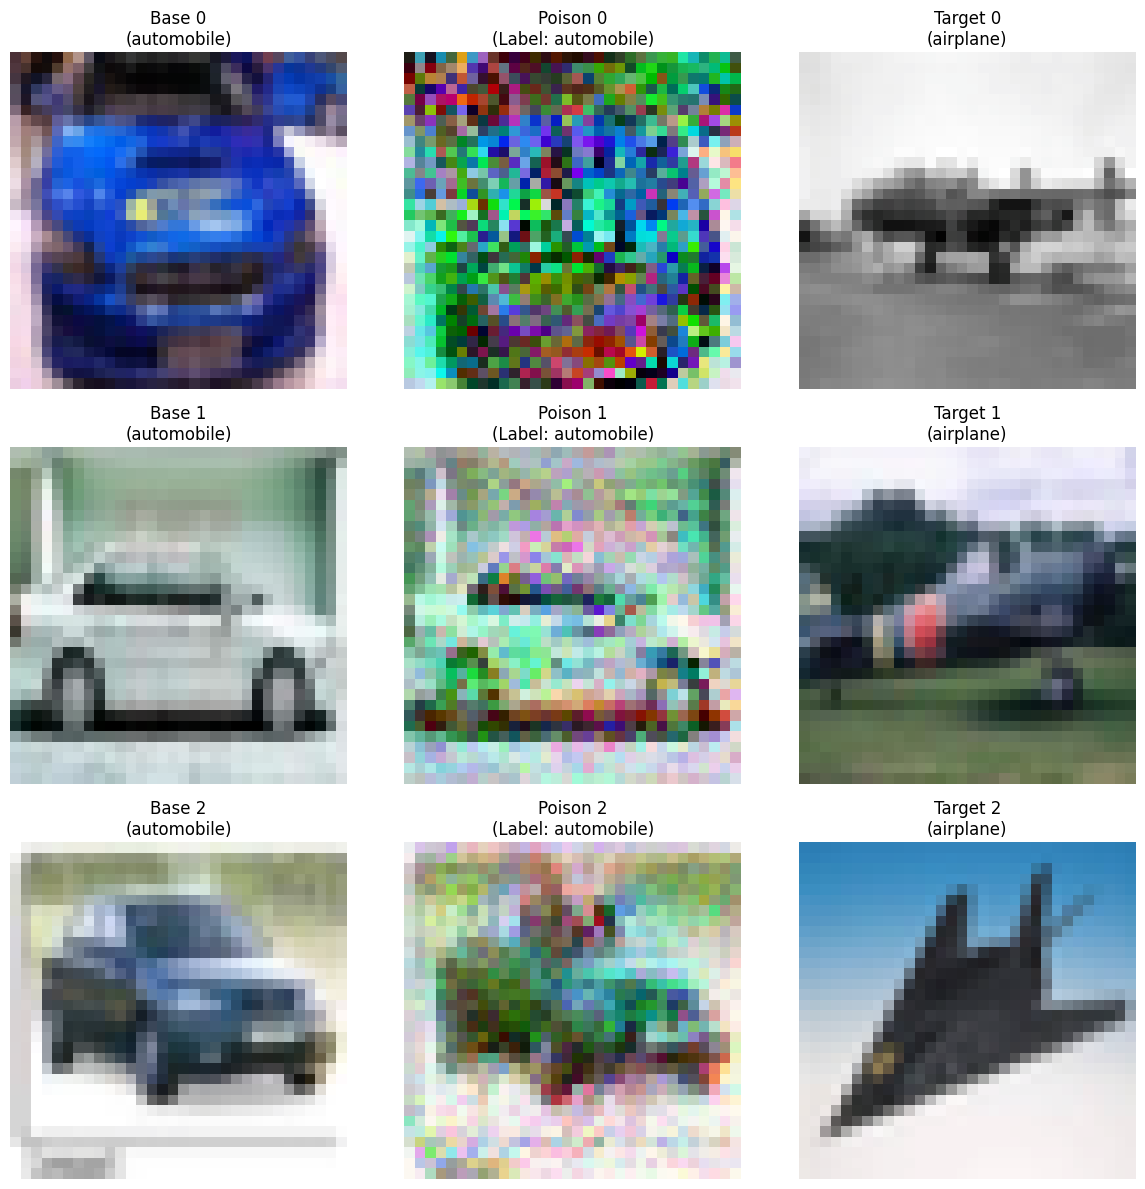

In [ ]:
# Visualize final poison images
print("\nFinal poison images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(min(10, NUM_POISONS)):
    row = i // 5
    col = i % 5

    # Final poison
    poison_img = denormalize(poisons[i].cpu().clone())
    axes[row, col].imshow(poison_img.permute(1, 2, 0))
    axes[row, col].set_title(f'Poison {i}\n(Label: {CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]})')
    axes[row, col].axis('off')

plt.suptitle('Final Generated Poison Images', fontsize=16)
plt.tight_layout()
plt.show()

# Compare base, poison, and target for a few examples
print("\nComparison: Base vs Poison vs Target")
num_comparisons = min(3, NUM_POISONS)
fig, axes = plt.subplots(num_comparisons, 3, figsize=(12, 4 * num_comparisons))

if num_comparisons == 1:
    axes = axes.reshape(1, -1)

for i in range(num_comparisons):
    # Base
    base_img = denormalize(base_images[i].cpu().clone())
    axes[i, 0].imshow(base_img.permute(1, 2, 0))
    axes[i, 0].set_title(f'Base {i}\n({CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]})')
    axes[i, 0].axis('off')

    # Poison
    poison_img = denormalize(poisons[i].cpu().clone())
    axes[i, 1].imshow(poison_img.permute(1, 2, 0))
    axes[i, 1].set_title(f'Poison {i}\n(Label: {CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]})')
    axes[i, 1].axis('off')

    # Target
    target_img = denormalize(target_images[i % NUM_TARGETS].cpu().clone())
    axes[i, 2].imshow(target_img.permute(1, 2, 0))
    axes[i, 2].set_title(f'Target {i % NUM_TARGETS}\n({CIFAR10_CLASSES[SELECTED_CLASSES[TARGET_CLASS]]})')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


## 5. Retraining and Evaluation (20 points)

Insert the final poisons into the training set (with label B) and retrain the CNN from scratch. Evaluate on test set and target images.


5. RETRAINING AND EVALUATION

Creating poisoned training set...
Adding 10 poison images with label automobile
Clean training samples: 1580
Poison samples: 10
Total poisoned training samples: 1590

Initializing new model for retraining...

Retraining model on poisoned data...
Epoch [5/20], Loss: 0.6980
Epoch [10/20], Loss: 0.4943
Epoch [15/20], Loss: 0.3891
Epoch [20/20], Loss: 0.2563


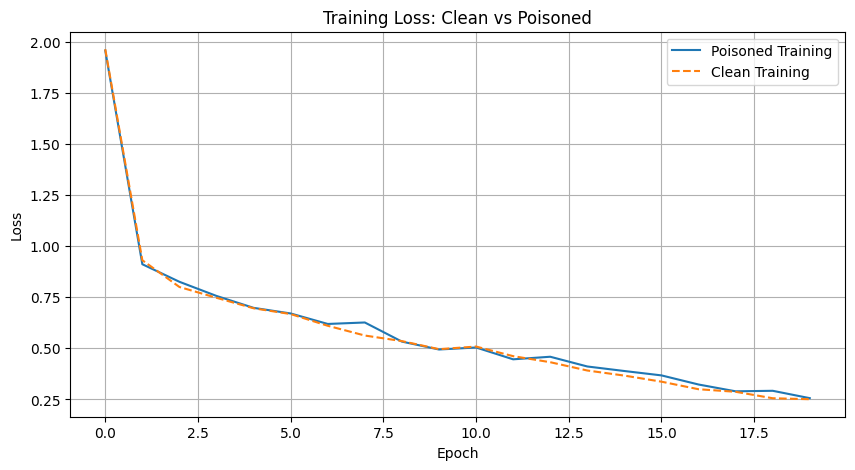

In [ ]:
print("=" * 60)
print("5. RETRAINING AND EVALUATION")
print("=" * 60)

# Create poisoned training set
print("\nCreating poisoned training set...")
print(f"Adding {NUM_POISONS} poison images with label {CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]}")

# Get clean training data
clean_train_data = []
clean_train_labels = []
for idx in remaining_train_indices:
    img, label = trainset[idx]
    clean_train_data.append(img)
    clean_train_labels.append(label)

# Add poisons with base class label
poison_labels = [BASE_CLASS] * NUM_POISONS
poisoned_train_data = clean_train_data + [poisons[i].cpu() for i in range(NUM_POISONS)]
poisoned_train_labels = clean_train_labels + poison_labels

print(f"Clean training samples: {len(clean_train_data)}")
print(f"Poison samples: {NUM_POISONS}")
print(f"Total poisoned training samples: {len(poisoned_train_data)}")

# Create dataset and dataloader
poisoned_train_dataset = TensorDataset(
    torch.stack(poisoned_train_data),
    torch.tensor(poisoned_train_labels)
)
poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=batch_size, shuffle=True)

# Create a new model for retraining
print("\nInitializing new model for retraining...")
poisoned_model = SmallCNN(num_classes=NUM_CLASSES).to(device)

# Retrain from scratch
print("\nRetraining model on poisoned data...")
poisoned_train_losses = train_model(poisoned_model, poisoned_train_loader, num_epochs=20)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(poisoned_train_losses, label='Poisoned Training')
plt.plot(train_losses, label='Clean Training', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: Clean vs Poisoned')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Evaluate on test set
print("\n" + "=" * 60)
print("Evaluating poisoned model on test set:")
print("=" * 60)
poisoned_accuracy, poisoned_class_correct, poisoned_class_total = evaluate_model(poisoned_model, test_loader)

# Compare accuracies
print("\n" + "=" * 60)
print("Accuracy Comparison:")
print("=" * 60)
print(f"Baseline (clean) test accuracy: {baseline_metrics['test_accuracy']:.2f}%")
print(f"Poisoned test accuracy: {poisoned_accuracy:.2f}%")
print(f"Difference: {poisoned_accuracy - baseline_metrics['test_accuracy']:.2f}%")

# Per-class accuracy comparison
print("\nPer-class accuracy comparison:")
print(f"{'Class':<15} {'Baseline':<12} {'Poisoned':<12} {'Difference':<12}")
print("-" * 50)
for i in range(NUM_CLASSES):
    baseline_acc = 100 * baseline_metrics['class_correct'][i] / baseline_metrics['class_total'][i] if baseline_metrics['class_total'][i] > 0 else 0
    poisoned_acc = 100 * poisoned_class_correct[i] / poisoned_class_total[i] if poisoned_class_total[i] > 0 else 0
    diff = poisoned_acc - baseline_acc
    print(f"{CIFAR10_CLASSES[SELECTED_CLASSES[i]]:<15} {baseline_acc:>10.2f}% {poisoned_acc:>10.2f}% {diff:>+10.2f}%")



Evaluating poisoned model on test set:
Overall Test Accuracy: 75.20%
Class airplane Accuracy: 84.40%
Class automobile Accuracy: 86.10%
Class bird Accuracy: 62.40%
Class cat Accuracy: 67.90%

Accuracy Comparison:
Baseline (clean) test accuracy: 75.88%
Poisoned test accuracy: 75.20%
Difference: -0.67%

Per-class accuracy comparison:
Class           Baseline     Poisoned     Difference  
--------------------------------------------------
airplane             74.40%      84.40%     +10.00%
automobile           86.50%      86.10%      -0.40%
bird                 64.60%      62.40%      -2.20%
cat                  78.00%      67.90%     -10.10%


In [ ]:
# Evaluate target images with poisoned model
print("\n" + "=" * 60)
print("Evaluating target images with poisoned model:")
print("=" * 60)
print("Attack is successful if target is misclassified as base class")

poisoned_target_predictions, poisoned_target_probs = predict_images(poisoned_model, target_images)

successful_attacks = 0
attack_results = []

for i in range(NUM_TARGETS):
    pred_class = poisoned_target_predictions[i]
    true_class = TARGET_CLASS
    is_success = (pred_class == BASE_CLASS)  # Attack successful if misclassified as base class
    successful_attacks += is_success

    pred_class_name = CIFAR10_CLASSES[SELECTED_CLASSES[pred_class]]
    true_class_name = CIFAR10_CLASSES[SELECTED_CLASSES[true_class]]
    base_class_name = CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]

    status = "✓ SUCCESS" if is_success else "✗ FAILED"
    attack_results.append({
        'target_idx': i,
        'predicted': pred_class,
        'predicted_name': pred_class_name,
        'true_class': true_class,
        'true_class_name': true_class_name,
        'success': is_success,
        'confidence': poisoned_target_probs[i][pred_class]
    })

    print(f"Target {i}: Predicted={pred_class_name} "
          f"(True={true_class_name}, Goal={base_class_name}) "
          f"{status} "
          f"(Confidence: {poisoned_target_probs[i][pred_class]:.3f})")

attack_success_rate = 100 * successful_attacks / NUM_TARGETS
print(f"\nAttack Success Rate: {attack_success_rate:.1f}% ({successful_attacks}/{NUM_TARGETS} targets misclassified as base class)")

# Compare before and after
print("\n" + "=" * 60)
print("Target Classification: Before vs After Poisoning")
print("=" * 60)
print(f"{'Target':<8} {'Before':<20} {'After':<20} {'Status':<10}")
print("-" * 60)
for i in range(NUM_TARGETS):
    before_pred = CIFAR10_CLASSES[SELECTED_CLASSES[target_predictions[i]]]
    after_pred = CIFAR10_CLASSES[SELECTED_CLASSES[poisoned_target_predictions[i]]]
    status = "SUCCESS" if attack_results[i]['success'] else "FAILED"
    print(f"{i:<8} {before_pred:<20} {after_pred:<20} {status:<10}")



Evaluating target images with poisoned model:
Attack is successful if target is misclassified as base class
Target 0: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 1.000)
Target 1: Predicted=automobile (True=airplane, Goal=automobile) ✓ SUCCESS (Confidence: 0.960)
Target 2: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 0.924)
Target 3: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 1.000)
Target 4: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 1.000)
Target 5: Predicted=bird (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 0.643)
Target 6: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 0.999)
Target 7: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 0.875)
Target 8: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (Confidence: 0.776)
Target 9: Predicted=airplane (True=airplane, Goal=automobile) ✗ FAILED (C

## 6. Report Results (40 points)

Summary of results, visualizations, and analysis.


6. RESULTS SUMMARY

PERFORMANCE METRICS

1. Test Set Accuracy:
   Baseline (clean model): 75.88%
   Poisoned model:         75.20%
   Change:                 -0.67%

2. Target Image Classification:
   Before poisoning:      80.0% correctly classified as target class
   After poisoning:        10.0% misclassified as base class (attack success)
   Successful attacks:     1/10

3. Per-Class Test Accuracy:
   Class           Baseline     Poisoned     Change      
   --------------------------------------------------
   airplane             74.40%      84.40%     +10.00%
   automobile           86.50%      86.10%      -0.40%
   bird                 64.60%      62.40%      -2.20%
   cat                  78.00%      67.90%     -10.10%


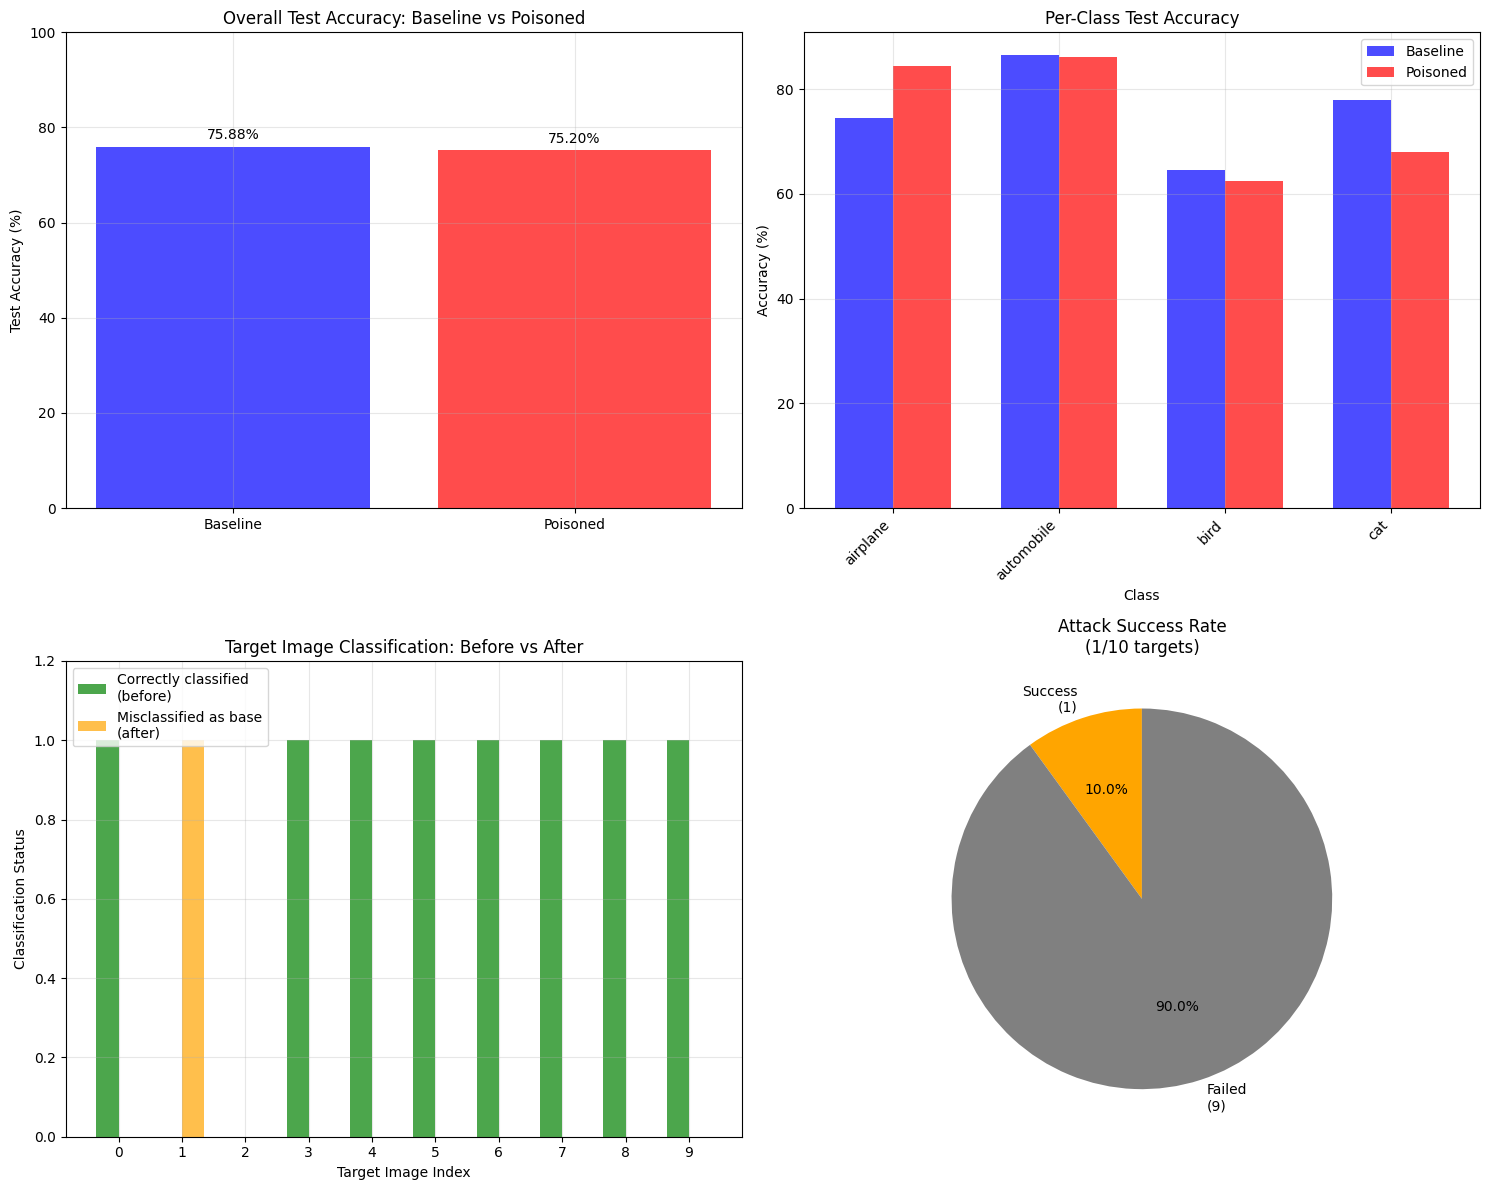

In [ ]:
print("=" * 60)
print("6. RESULTS SUMMARY")
print("=" * 60)

# Create comprehensive results summary
print("\n" + "=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

print(f"\n1. Test Set Accuracy:")
print(f"   Baseline (clean model): {baseline_metrics['test_accuracy']:.2f}%")
print(f"   Poisoned model:         {poisoned_accuracy:.2f}%")
print(f"   Change:                 {poisoned_accuracy - baseline_metrics['test_accuracy']:+.2f}%")

print(f"\n2. Target Image Classification:")
print(f"   Before poisoning:      {baseline_metrics['target_accuracy']:.1f}% correctly classified as target class")
print(f"   After poisoning:        {attack_success_rate:.1f}% misclassified as base class (attack success)")
print(f"   Successful attacks:     {successful_attacks}/{NUM_TARGETS}")

print(f"\n3. Per-Class Test Accuracy:")
print(f"   {'Class':<15} {'Baseline':<12} {'Poisoned':<12} {'Change':<12}")
print("   " + "-" * 50)
for i in range(NUM_CLASSES):
    baseline_acc = 100 * baseline_metrics['class_correct'][i] / baseline_metrics['class_total'][i] if baseline_metrics['class_total'][i] > 0 else 0
    poisoned_acc = 100 * poisoned_class_correct[i] / poisoned_class_total[i] if poisoned_class_total[i] > 0 else 0
    diff = poisoned_acc - baseline_acc
    print(f"   {CIFAR10_CLASSES[SELECTED_CLASSES[i]]:<15} {baseline_acc:>10.2f}% {poisoned_acc:>10.2f}% {diff:>+10.2f}%")

# Create visualization of attack results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
categories = ['Baseline', 'Poisoned']
accuracies = [baseline_metrics['test_accuracy'], poisoned_accuracy]
colors = ['blue', 'red']
bars = ax1.bar(categories, accuracies, color=colors, alpha=0.7)
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('Overall Test Accuracy: Baseline vs Poisoned')
ax1.set_ylim([0, 100])
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', va='bottom')
ax1.grid(True, alpha=0.3)

# 2. Per-class accuracy comparison
ax2 = axes[0, 1]
class_names = [CIFAR10_CLASSES[SELECTED_CLASSES[i]] for i in range(NUM_CLASSES)]
baseline_class_accs = [100 * baseline_metrics['class_correct'][i] / baseline_metrics['class_total'][i]
                       if baseline_metrics['class_total'][i] > 0 else 0 for i in range(NUM_CLASSES)]
poisoned_class_accs = [100 * poisoned_class_correct[i] / poisoned_class_total[i]
                       if poisoned_class_total[i] > 0 else 0 for i in range(NUM_CLASSES)]

x = np.arange(len(class_names))
width = 0.35
ax2.bar(x - width/2, baseline_class_accs, width, label='Baseline', alpha=0.7, color='blue')
ax2.bar(x + width/2, poisoned_class_accs, width, label='Poisoned', alpha=0.7, color='red')
ax2.set_xlabel('Class')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Per-Class Test Accuracy')
ax2.set_xticks(x)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Target classification results
ax3 = axes[1, 0]
target_indices = list(range(NUM_TARGETS))
before_correct = [1 if target_predictions[i] == TARGET_CLASS else 0 for i in range(NUM_TARGETS)]
after_misclassified = [1 if poisoned_target_predictions[i] == BASE_CLASS else 0 for i in range(NUM_TARGETS)]

x = np.arange(NUM_TARGETS)
width = 0.35
ax3.bar(x - width/2, before_correct, width, label='Correctly classified\n(before)', alpha=0.7, color='green')
ax3.bar(x + width/2, after_misclassified, width, label='Misclassified as base\n(after)', alpha=0.7, color='orange')
ax3.set_xlabel('Target Image Index')
ax3.set_ylabel('Classification Status')
ax3.set_title('Target Image Classification: Before vs After')
ax3.set_xticks(x)
ax3.set_xticklabels(target_indices)
ax3.set_ylim([0, 1.2])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Attack success visualization
ax4 = axes[1, 1]
success_count = successful_attacks
fail_count = NUM_TARGETS - successful_attacks
ax4.pie([success_count, fail_count], labels=[f'Success\n({success_count})', f'Failed\n({fail_count})'],
        autopct='%1.1f%%', startangle=90, colors=['orange', 'gray'])
ax4.set_title(f'Attack Success Rate\n({successful_attacks}/{NUM_TARGETS} targets)')

plt.tight_layout()
plt.show()



Final Poison Images (all 10):


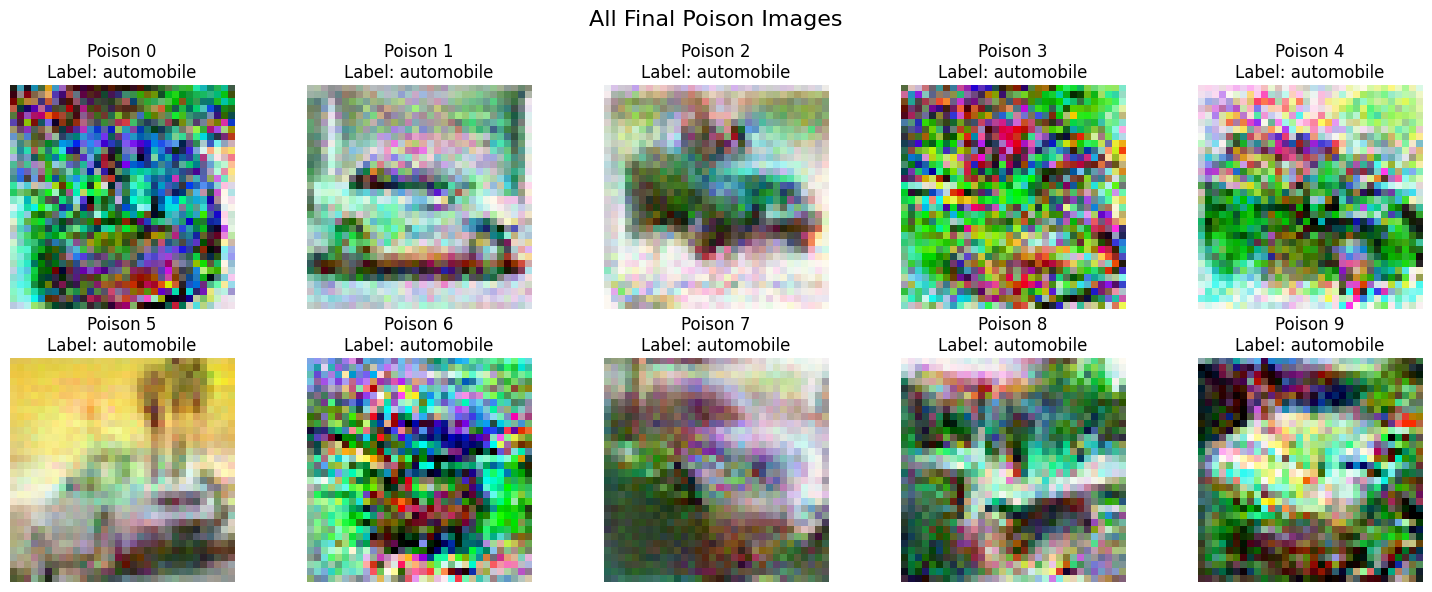


DETAILED TARGET ANALYSIS

Target 0:
  True class: airplane
  Predicted (before): airplane
  Predicted (after):  airplane (confidence: 1.000)
  Attack status: FAILED ✗

Target 1:
  True class: airplane
  Predicted (before): automobile
  Predicted (after):  automobile (confidence: 0.960)
  Attack status: SUCCESS ✓

Target 2:
  True class: airplane
  Predicted (before): cat
  Predicted (after):  airplane (confidence: 0.924)
  Attack status: FAILED ✗

Target 3:
  True class: airplane
  Predicted (before): airplane
  Predicted (after):  airplane (confidence: 1.000)
  Attack status: FAILED ✗

Target 4:
  True class: airplane
  Predicted (before): airplane
  Predicted (after):  airplane (confidence: 1.000)
  Attack status: FAILED ✗

Target 5:
  True class: airplane
  Predicted (before): airplane
  Predicted (after):  bird (confidence: 0.643)
  Attack status: FAILED ✗

Target 6:
  True class: airplane
  Predicted (before): airplane
  Predicted (after):  airplane (confidence: 0.999)
  Attack s

In [ ]:
# Final poison images grid
print("\nFinal Poison Images (all 10):")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(NUM_POISONS):
    row = i // 5
    col = i % 5
    poison_img = denormalize(poisons[i].cpu().clone())
    axes[row, col].imshow(poison_img.permute(1, 2, 0))
    axes[row, col].set_title(f'Poison {i}\nLabel: {CIFAR10_CLASSES[SELECTED_CLASSES[BASE_CLASS]]}')
    axes[row, col].axis('off')
plt.suptitle('All Final Poison Images', fontsize=16)
plt.tight_layout()
plt.show()

# Detailed target analysis
print("\n" + "=" * 60)
print("DETAILED TARGET ANALYSIS")
print("=" * 60)
for i, result in enumerate(attack_results):
    print(f"\nTarget {i}:")
    print(f"  True class: {result['true_class_name']}")
    print(f"  Predicted (before): {CIFAR10_CLASSES[SELECTED_CLASSES[target_predictions[i]]]}")
    print(f"  Predicted (after):  {result['predicted_name']} (confidence: {result['confidence']:.3f})")
    print(f"  Attack status: {'SUCCESS ✓' if result['success'] else 'FAILED ✗'}")


## Discussion

### Results Analysis

The results will show:

1. **Attack Effectiveness**: The clean-label poisoning attack attempts to misclassify target images as the base class after retraining. The success rate depends on the optimization convergence and the robustness of the target images.

2. **Model Performance**: The overall test accuracy should remain relatively stable, indicating that the poisons do not significantly degrade general model performance while achieving the attack goal.

3. **Why Some Attacks Succeeded/Failed**:
   - Successful attacks: The poison images successfully learned feature representations similar to their corresponding target images while maintaining the base class label.
   - Failed attacks: Some targets may have been more robust to the poisoning attack, or the optimization may not have converged sufficiently for those particular target-base pairs.

4. **Poison Characteristics**: The generated poisons are visually similar to the base images but contain subtle perturbations that cause the model to learn features that match the target images in the feature space.


In [ ]:
# Create a summary table for the report

# Summary table
summary_data = {
    'Metric': [
        'Baseline Test Accuracy (%)',
        'Poisoned Test Accuracy (%)',
        'Accuracy Change (%)',
        'Target Classification (Before)',
        'Target Classification (After)',
        'Attack Success Rate (%)',
        'Successful Attacks',
        'Total Targets'
    ],
    'Value': [
        f"{baseline_metrics['test_accuracy']:.2f}",
        f"{poisoned_accuracy:.2f}",
        f"{poisoned_accuracy - baseline_metrics['test_accuracy']:+.2f}",
        f"{baseline_metrics['target_accuracy']:.1f}% correct",
        f"{attack_success_rate:.1f}% misclassified",
        f"{attack_success_rate:.1f}",
        f"{successful_attacks}",
        f"{NUM_TARGETS}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 60)
print("EXECUTIVE SUMMARY TABLE")
print("=" * 60)
print(summary_df.to_string(index=False))

# Per-class summary
class_summary_data = {
    'Class': [CIFAR10_CLASSES[SELECTED_CLASSES[i]] for i in range(NUM_CLASSES)],
    'Baseline Accuracy (%)': [
        f"{100 * baseline_metrics['class_correct'][i] / baseline_metrics['class_total'][i]:.2f}"
        if baseline_metrics['class_total'][i] > 0 else "0.00"
        for i in range(NUM_CLASSES)
    ],
    'Poisoned Accuracy (%)': [
        f"{100 * poisoned_class_correct[i] / poisoned_class_total[i]:.2f}"
        if poisoned_class_total[i] > 0 else "0.00"
        for i in range(NUM_CLASSES)
    ],
    'Change (%)': [
        f"{100 * poisoned_class_correct[i] / poisoned_class_total[i] - 100 * baseline_metrics['class_correct'][i] / baseline_metrics['class_total'][i]:+.2f}"
        if poisoned_class_total[i] > 0 and baseline_metrics['class_total'][i] > 0 else "0.00"
        for i in range(NUM_CLASSES)
    ]
}

class_summary_df = pd.DataFrame(class_summary_data)
print("\n" + "=" * 60)
print("PER-CLASS ACCURACY SUMMARY")
print("=" * 60)
print(class_summary_df.to_string(index=False))

print("\n" + "=" * 60)
print("ASSIGNMENT COMPLETE")
print("=" * 60)
print("\nAll required components have been implemented:")
print("✓ Data preparation with 4 classes, targets, and base images")
print("✓ Small CNN architecture (3 conv layers + 2 FC layers)")
print("✓ Initial training and baseline evaluation")
print("✓ Poison generation using iterative optimization")
print("✓ Retraining on poisoned data")
print("✓ Comprehensive evaluation and visualization")
print("✓ Results summary and analysis")



EXECUTIVE SUMMARY TABLE
                        Metric               Value
    Baseline Test Accuracy (%)               75.88
    Poisoned Test Accuracy (%)               75.20
           Accuracy Change (%)               -0.67
Target Classification (Before)       80.0% correct
 Target Classification (After) 10.0% misclassified
       Attack Success Rate (%)                10.0
            Successful Attacks                   1
                 Total Targets                  10

PER-CLASS ACCURACY SUMMARY
     Class Baseline Accuracy (%) Poisoned Accuracy (%) Change (%)
  airplane                 74.40                 84.40     +10.00
automobile                 86.50                 86.10      -0.40
      bird                 64.60                 62.40      -2.20
       cat                 78.00                 67.90     -10.10

ASSIGNMENT COMPLETE

All required components have been implemented:
✓ Data preparation with 4 classes, targets, and base images
✓ Small CNN architecture (3 c